In [17]:
import scipy.stats as stats
from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize
import numpy as np
% matplotlib inline
figsize(12.5, 4)
from mpl_toolkits.mplot3d import Axes3D

Text(0.5, 0.92, 'Alternate view')

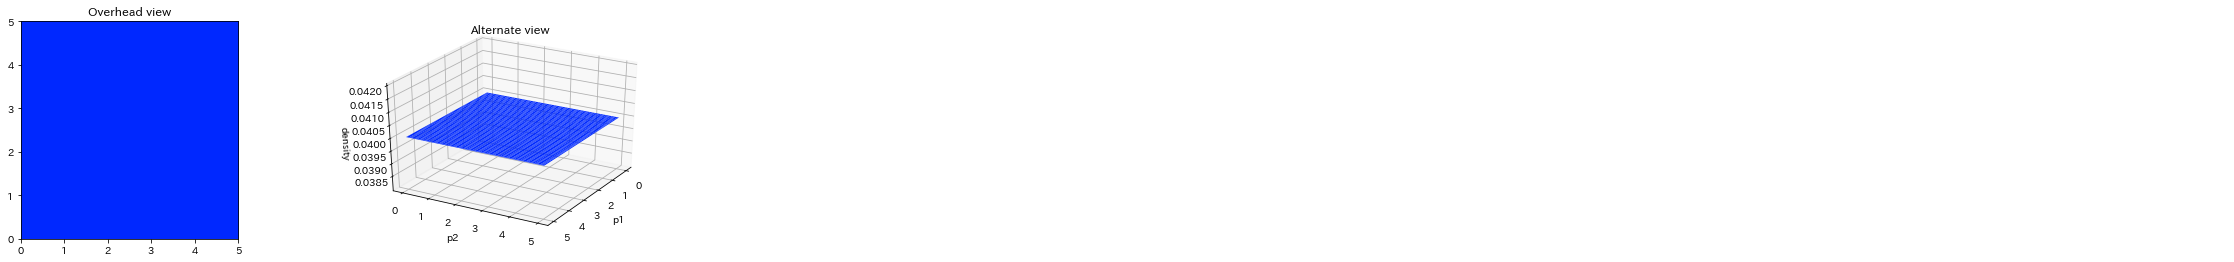

In [18]:
jet = plt.cm.jet
fig = plt.figure()

x = y = np.linspace(0, 5, 100)
X, Y = np.meshgrid(x, y)

plt.subplot(121)
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(y, loc=0, scale=5)
M = np.dot(uni_x[:, None], uni_y[None, :])
im = plt.imshow(M, interpolation='none', origin='lower', cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))

plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Overhead view")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=jet, vmax=1, vmin=-.15) # 3dグラフ
ax.view_init(azim=390) # 目線の角度
ax.set_xlabel("p1")
ax.set_ylabel("p2")
ax.set_zlabel("density")
plt.title("Alternate view")


Text(0.5, 0.92, 'Alternate view')

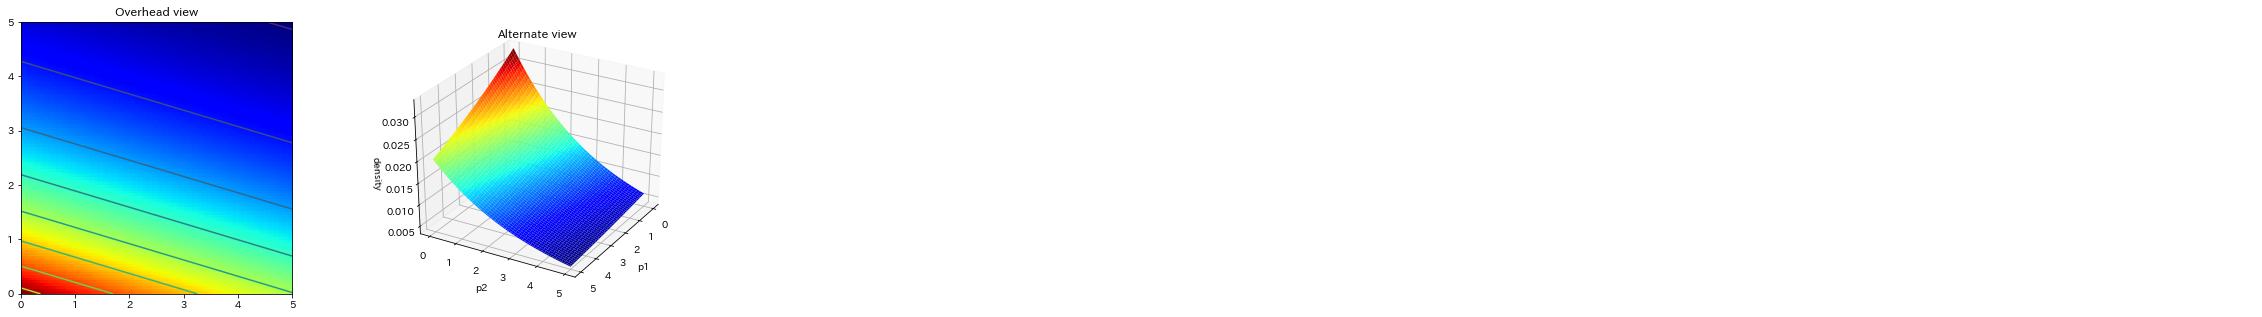

In [24]:
figsize(12.5, 5)
fig = plt.figure()
plt.subplot(121)

exp_x = stats.expon.pdf(x, scale=3) # scale = 尺度母数 = 1/λ = E[x]
exp_y = stats.expon.pdf(y, scale=10)
M = np.dot(exp_x[:, None], exp_y[None, :])
CS = plt.contour(X, Y, M)
im = plt.imshow(M, cmap=jet, origin='lower', extent=(0, 5, 0, 5))
plt.title("Overhead view")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=jet)
ax.view_init(azim=390)
ax.set_xlabel('p1')
ax.set_ylabel('p2')
ax.set_zlabel('density')
plt.title("Alternate view")

In [20]:
# 観測データの生成

# 観測データのサンプルサイズ
N=1

# 真のパラメーター. 本当は分からない
lambda_1_true = 1
lambda_2_true = 3

# 2つのパラメーターからデータを生成する
data = np.concatenate([
    stats.poisson.rvs(lambda_1_true, size=(N, 1)),
    stats.poisson.rvs(lambda_2_true, size=(N, 1))
], axis=1)

print("observed (2-dimensional, sample size = {}: {})".format(N, data))

# plot
x = y = np.linspace(.01, 5, 100)

# 平均μが0.01~5の間にある100個のポアソン分布を適用したときに、
# 観測データの生じる確率をarrayにしている
likelihood_x = np.array([stats.poisson.pmf(data[:, 0], _x) for _x in x]).prod(axis=1)
likelihood_y = np.array([stats.poisson.pmf(data[:, 1], _y) for _y in y]).prod(axis=1)

L = np.dot(likelihood_x[:, None], likelihood_y[None, :]) # 各パラメーターのデータに対する尤度

observed (2-dimensional, sample size = 1: [[3 4]])


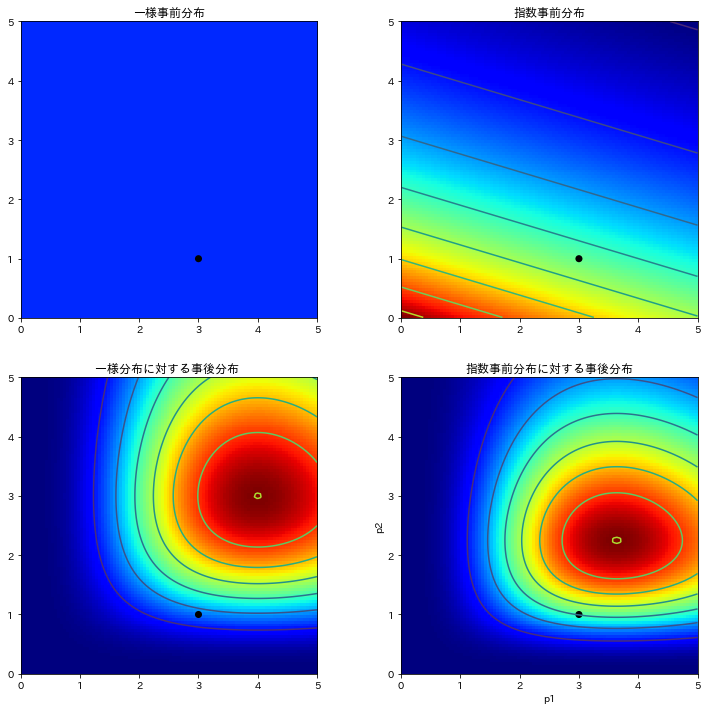

In [47]:
figsize(12.5, 12)

plt.subplot(221)
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(x, loc=0, scale=5)
M = np.dot(uni_x[:, None], uni_y[None, :]) # 一様分布
plt.imshow(M, cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50,edgecolors="none")
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("一様事前分布")

plt.subplot(223)
plt.contour(x, y, M * L) # 等高線, 尤度と事前分布の積が事後分布となる
plt.imshow(M * L, cmap=jet, origin='lower', extent=(0, 5, 0, 5))
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolors="none")
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("一様分布に対する事後分布 ".format(N))

plt.subplot(222)
exp_x = stats.expon.pdf(x, loc=0, scale=3)
exp_y = stats.expon.pdf(y, loc=0, scale=10)
M = np.dot(exp_x[:, None], exp_y[None, :]) # 指数事前分布
plt.contour(x, y, M)
plt.imshow(M, cmap=jet, origin='lower', extent=(0, 5, 0, 5))
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolors="none")
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("指数事前分布")

plt.subplot(224)
plt.contour(x, y, M * L)
plt.imshow(M * L, cmap=jet, origin='lower', extent=(0, 5, 0, 5))
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolors="none")
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.xlabel("p1")
plt.ylabel("p2")
plt.title("指数事前分布に対する事後分布")

plt.show()

## 3.1.4 例題:混合モデルの教師なしクラスタリング

In [131]:
from os import makedirs
makedirs("data", exist_ok=True)
from urllib.request import urlretrieve
urlretrieve("https://git.io/vXt6b", "data/mixture_data.csv")

('data/mixture_data.csv', <http.client.HTTPMessage at 0x1a41c329b0>)

[115.85679142 152.26153716 178.87449059 162.93500815 107.02820697
 105.19141146 118.38288501 125.3769803  102.88054011 206.71326136] ...


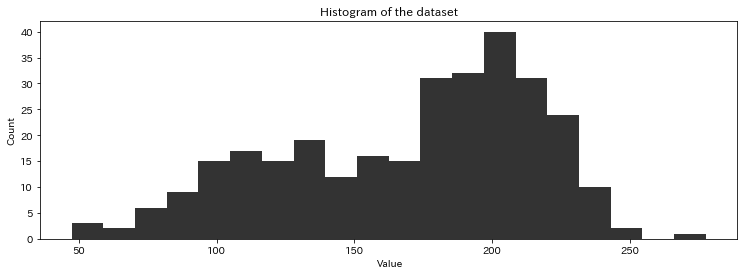

In [132]:
figsize(12.5, 4)

data = np.loadtxt("data/mixture_data.csv", delimiter=",")
plt.hist(data, bins=20, color="k",
        histtype="stepfilled", alpha=0.8)

plt.title("Histogram of the dataset")
plt.ylim([0, None])
plt.xlabel('Value') # 値
plt.ylabel('Count') # 個数
print(data[:10], "...")

In [133]:
import pymc as pm
p = pm.Uniform("p", 0., 1.)
assignment = pm.Categorical("assignment", [p, 1-p], size=data.shape[0])
print("事前確率pでのクラスタの割当, with p = {}".format(p.value))
print(assignment.value[:10], "...")

事前確率pでのクラスタの割当, with p = 0.7164322867551812
[1 0 0 0 1 0 0 0 0 0] ...


In [134]:
taus = 1.0 / pm.Uniform("stds", 0, 33, size=2)**2 # 精度τ = 1/σ**2
 # センターの事前分布を正規分布で設定. パラメーターは見た目から
centers = pm.Normal("centers", [120, 190], [0.01, 0.01], size=2)

@pm.deterministic
def center_i(assignment=assignment, centers=centers):
    return centers[assignment]

@pm.deterministic
def tau_i(assignment=assignment, taus=taus):
    return taus[assignment]

print("ランダムな割当: ", assignment.value[:4], "...")
print("割り当てられた中心", center_i.value[:4], "...")
print("割り当てられた精度: ", tau_i.value[:4], "...")

ランダムな割当:  [1 0 0 0] ...
割り当てられた中心 [194.41628231  95.80888342  95.80888342  95.80888342] ...
割り当てられた精度:  [0.00359107 0.01186712 0.01186712 0.01186712] ...


In [135]:
# このモデルに観測を結びつける
observations = pm.Normal("obs", center_i, tau_i, value=data, observed=True)

# 新しいModelクラスのオブジェクトを作成する
model = pm.Model([p, assignment, taus, centers])


In [136]:
mcmc = pm.MCMC(model)
mcmc.sample(50000)

 [-----------------100%-----------------] 50000 of 50000 complete in 15.3 sec

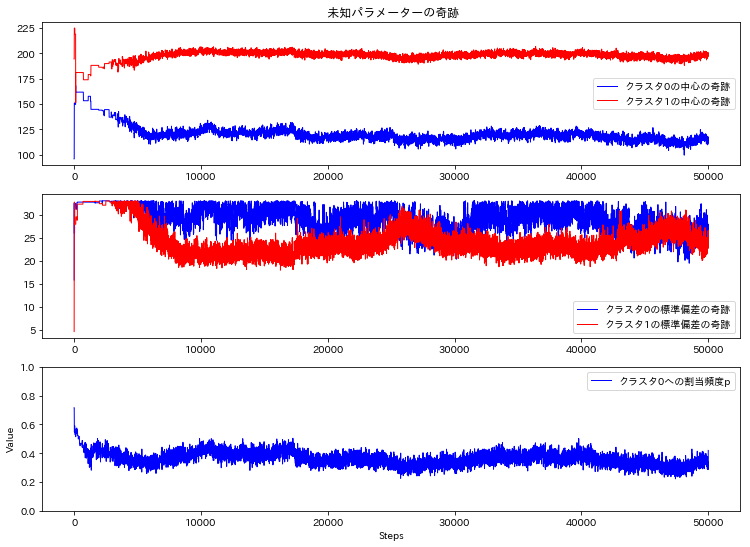

In [137]:
figsize(12.5, 9)
line_width = 1

colors = ["red", "blue"]

center_trace = mcmc.trace("centers")[:]
if center_trace[-1, 0] < center_trace[-1, 1]:
    # 値の大小で色の入れ替え
    colors = ["blue", "red"]

plt.subplot(311)
plt.plot(center_trace[:, 0], label="クラスタ0の中心の奇跡", c=colors[0], lw = line_width)
plt.plot(center_trace[:, 1], label="クラスタ1の中心の奇跡", c=colors[1], lw = line_width)
plt.title(" 未知パラメーターの奇跡")
leg = plt.legend()
leg.get_frame().set_alpha(0.7)

plt.subplot(312)
std_trace = mcmc.trace("stds")[:]
plt.plot(std_trace[:, 0], label="クラスタ0の標準偏差の奇跡", c=colors[0], lw=line_width)
plt.plot(std_trace[:, 1], label="クラスタ1の標準偏差の奇跡", c=colors[1], lw=line_width)
plt.legend()

plt.subplot(313)
p_trace = mcmc.trace("p")[:]
plt.plot(p_trace, label="クラスタ0への割当頻度p", c=colors[0], lw=line_width)
plt.xlabel("Steps")
plt.ylabel("Value")
plt.ylim(0, 1)
plt.legend()

In [138]:
mcmc.sample(100000)

 [-----------------100%-----------------] 100000 of 100000 complete in 30.1 sec

Text(0.5, 0, 'Steps')

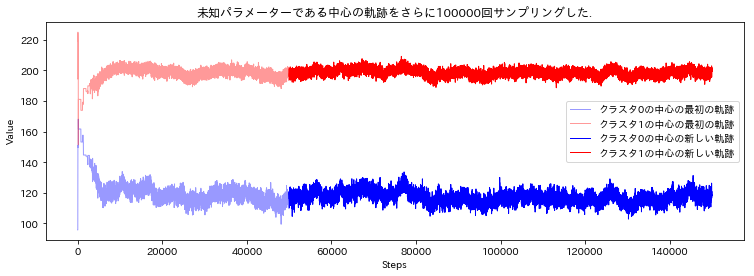

In [139]:
figsize(12.5, 4)
center_trace = mcmc.trace("centers", chain=1)[:]
prev_center_trace = mcmc.trace("centers", chain=0)[:]

x = np.arange(50000)
plt.plot(x, prev_center_trace[:, 0], label="クラスタ0の中心の最初の軌跡", lw=line_width, alpha=0.4, c=colors[0])
plt.plot(x, prev_center_trace[:, 1], label="クラスタ1の中心の最初の軌跡", lw=line_width, alpha=0.4, c=colors[1])

x = np.arange(50000, 150000)
plt.plot(x, center_trace[:, 0], label="クラスタ0の中心の新しい軌跡", lw=line_width, c=colors[0])
plt.plot(x, center_trace[:, 1], label="クラスタ1の中心の新しい軌跡", lw=line_width, c=colors[1])

plt.title("未知パラメーターである中心の軌跡をさらに100000回サンプリングした.")
leg = plt.legend()
leg.get_frame().set_alpha(0.8)
plt.ylabel("Value")
plt.xlabel("Steps")

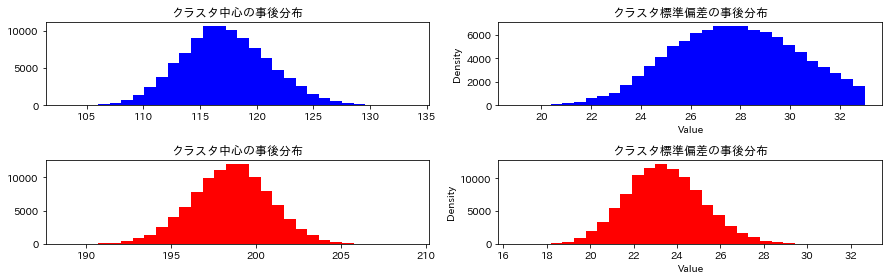

In [140]:
std_trace = mcmc.trace("stds")[:]

_i = [1, 2, 3, 4]
for i in range(2):
    plt.subplot(2, 2, _i[2 * i])
    plt.title("クラスタ中心の事後分布")
    plt.hist(center_trace[:, i], color=colors[i], bins=30, histtype="stepfilled")
    
    plt.subplot(2, 2, _i[2 * i + 1])
    plt.title("クラスタ標準偏差の事後分布")
    plt.hist(std_trace[:, i], color=colors[i], bins=30, histtype="stepfilled")
    plt.ylabel("Density")
    plt.xlabel("Value")
    
plt.tight_layout()

Text(0.5, 1.0, '事後分布からサンプリングしたデータ点のラベル')

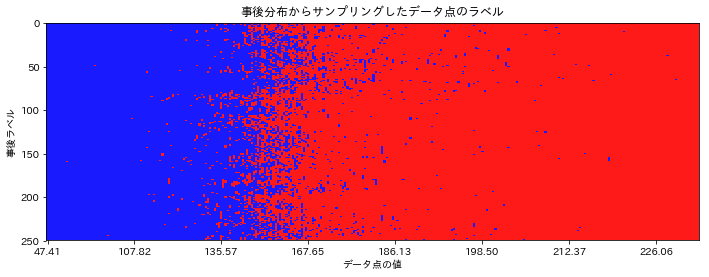

In [141]:
import matplotlib as mpl

plt.cmap = mpl.colors.ListedColormap(colors)
plt.imshow(mcmc.trace("assignment")[::400, np.argsort(data)], cmap=plt.cmap, aspect=.4, alpha=.9)

plt.xticks(np.arange(0, data.shape[0], 40), 
          ["%.2f" % s for s in np.sort(data)[::40]])
plt.ylabel("事後ラベル")
plt.xlabel("データ点の値")
plt.title("事後分布からサンプリングしたデータ点のラベル")

Text(0.5, 0, 'データ点の値')

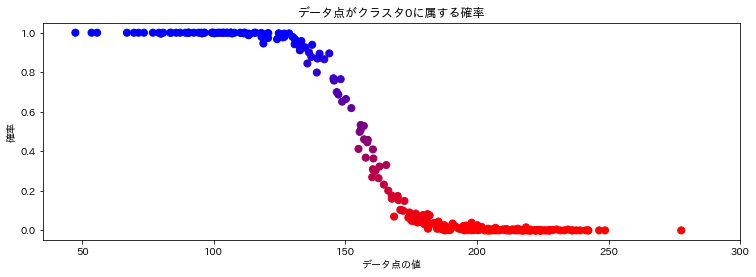

In [142]:
cmap = mpl.colors.LinearSegmentedColormap.from_list("BMH", colors)

assign_trace = mcmc.trace("assignment")[:]
plt.scatter(data, 1 - assign_trace.mean(axis=0), cmap=cmap, c=assign_trace.mean(axis=0), s=50)

plt.ylim(-0.05, 1.05)
plt.xlim(35, 300)
plt.title("データ点がクラスタ0に属する確率")
plt.ylabel("確率")
plt.xlabel("データ点の値")

### データを最もよく表す正規分布 -> サンプリングした事後分布の平均

/Users/yukisunami/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 1.0, '事後平均をパラメータにした正規分布によるクラスタの可視化')

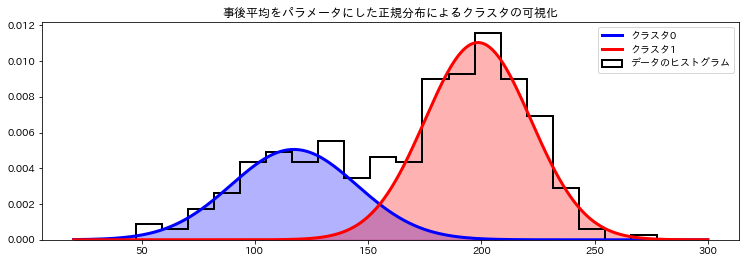

In [143]:
norm = stats.norm

x = np.linspace(20, 300, 500)
posterior_center_means = center_trace.mean(axis=0)
posterior_std_means = std_trace.mean(axis=0)
posterior_p_mean = mcmc.trace("p")[:].mean()

plt.hist(data, bins=20, histtype="step", normed=True, color="k", lw=2, label="データのヒストグラム")

# 縦軸は確率, p の値によって下につぶされる
y = posterior_p_mean * norm.pdf(x, loc=posterior_center_means[0], scale=posterior_std_means[0])

plt.plot(x, y, lw=3, color=colors[0], label="クラスタ0")
plt.fill_between(x, y, color=colors[0], alpha=0.3)

y = (1 - posterior_p_mean) * norm.pdf(x, loc=posterior_center_means[1], scale=posterior_std_means[1])

plt.plot(x, y, lw=3, color=colors[1], label="クラスタ1")
plt.fill_between(x, y, color=colors[1], alpha=0.3)

plt.legend()
plt.title("事後平均をパラメータにした正規分布によるクラスタの可視化")

 [-----------------100%-----------------] 500 of 500 complete in 0.0 sec

Text(0.5, 1.0, '未知数間の依存関係が極端な場合')

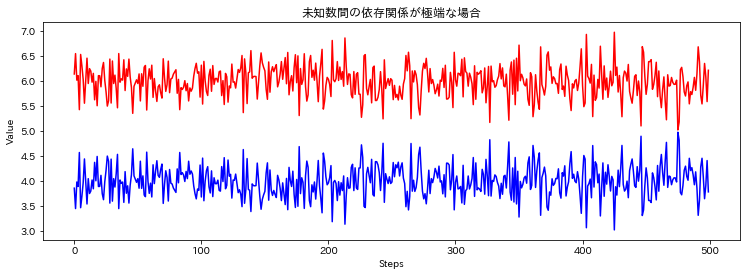

In [144]:
import pymc as pm

x = pm.Normal("x", 4, 10)
y = pm.Lambda("y", lambda x=x: 10 - x, trace=True)
ex_mcmc = pm.MCMC(pm.Model([x, y]))
ex_mcmc.sample(500)

plt.plot(ex_mcmc.trace("x")[:], color=colors[0])
plt.plot(ex_mcmc.trace("y")[:], color=colors[1])
plt.xlabel("Steps")
plt.ylabel("Value")
plt.title("未知数間の依存関係が極端な場合")

In [145]:
norm_pdf = stats.norm.pdf

p_trace = mcmc.trace("p")[:]
x = 175

v = p_trace * norm_pdf(x, 
                       loc=center_trace[:, 0],
                       scale=std_trace[:, 0]) < (1-p_trace) * norm_pdf(x,
                         loc=center_trace[:, 1], 
                         scale=std_trace[:, 1])

print("Probabilty of belonging to cluster 1:", v.mean())

Probabilty of belonging to cluster 1: 1.0


In [146]:
(1-p_trace) * norm_pdf(x,
                         loc=center_trace[:, 1], 
                         scale=std_trace[:, 1])

array([0.00564693, 0.00654658, 0.00655863, ..., 0.00568661, 0.00568661,
       0.00581937])

In [147]:
p_trace * norm_pdf(x, 
                       loc=center_trace[:, 0],
                       scale=std_trace[:, 0])

array([0.00037293, 0.00046578, 0.00052004, ..., 0.00089197, 0.00089197,
       0.00085383])

In [148]:
model = pm.Model([p, assignment, taus, centers])
map_ = pm.MAP(model)
map_.fit() # MAP値を各変数のValueに設定する

mcmc = pm.MCMC(model)
mcmc.sample(100000, 50000) # 第二引数がバーンイン

 [-----------------100%-----------------] 100000 of 100000 complete in 27.4 sec